# RANSAC Core

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

## Generate Some Data

In [3]:
n = 50
sigma = 20.0

In [4]:
x = 10 + np.array(range(n))

In [5]:
y = 0.001 * x * x + 3 * x + sigma * np.random.randn(n)

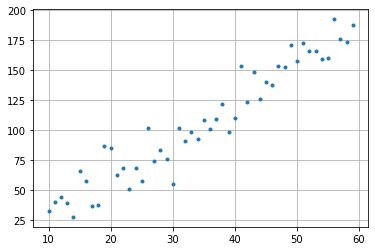

In [6]:
plt.plot(x,y,'.')
plt.grid()

## Define the RANSAC Object Template

In [7]:
class RANSAC_Core(object):
    """RANSAC Core Object defining fitted function.
    
        This is a template, it cannot be used directly.  A derived class must
        overwrite these methods:
        
            dof() - Return the number of degrees of freedom for the fit function
            
            fit() - Perform the fit and return the model from the arrays of
                            sampled x,y
                            
            predict()
            
        The derived class defines the function we're using to model the data
        and, along with the limit, define outliers.
        
        These methods can be used as-is once the above methods are 
        over-written.
        
            __init__ : Instantiate derived class with (x,y,limit)
            fitSamples()
            classify()
            iteration()
            run()
            plot()
        
    """
    def __init__(self,x:np.ndarray,y:np.ndarray,limit:float):
        """Initialize the RANSAC object with the data points and the consensus limit.
        
            This data does not change with an iteration of the RANSAC algorithm.
        
        """
        self.x = x
        self.y = y
        self.limit = limit
        self.n = len(x)
        self.bestResult = 0.
        assert(self.n == len(y))
    
    #
    ########################################################################
    #
    #  Overwrite these methods in the derived class
    #
    def dof(self)->int:
        """Returns the number of parameters to be used in the model.
        
            Overwrite this method in the derived class.
        """
        return 0
    
    def fit(self,x:np.ndarray,y:np.ndarray)->np.ndarray:
        """Return the model parameters from fitting the x,y samples.
        
            x, y are of length self.dof().  The expected return
            array is also of length self.dof().
            
            Overwrite this routine with the fit method for the particular
            model on which you are using RANSAC.
        """
        return np.ndarray([])
    
    def predict(self,param:np.ndarray,x:np.ndarray)->np.ndarray:
        """Return the modeled y values for x using param.
        
            Overwrite this routine with the predict method for the 
            particular model in use.
            
            The output array contains a prediction for each x.
        """
        return np.zeros_like(self.x)
    
    #######################################################################
    #
    def fitSamples(self):
        #
        #  Select the points randomly, insuring we have unique 'x' values
        #   in the samples
        #
        while True:
            pts = np.random.choice(len(self.x),self.dof(),replace=False)
            if len(np.unique(self.x[pts])) == self.dof():
                break
        
        self.pts = pts
        
        self.param = self.fit(self.x[self.pts],self.y[self.pts])
    
    def classify(self):
        """Classify data points as in or out of Consensus by checking limit."""
        
        self.yModel = self.predict(self.param,self.x)
        
        self.consensus = np.abs(self.y - self.yModel) < self.limit
    
    def iteration(self):
        
        self.fitSamples()
        self.classify()
        
        return self.consensus.sum() / self.n
    
    def run(self,success:float=0.95,maxIter:int=500):
        
        for i in range(maxIter):
            
            result = self.iteration()
            
            if result > self.bestResult:
                self.bestResult = result
                self.bestParam  = self.param
                self.bestPts    = self.pts
            
            if (result >= success):
                break
                
        if self.bestResult > result:
            
            self.param = self.bestParam
            self.pts   = self.bestPts
            self.classify()
            result = self.consensus.sum() / self.n
                
        return result
    
    def plot(self,title="RANSAC Result",filename=None):
        
        fig, ax = plt.subplots(figsize=(15,10))
        plt.plot(self.x,self.yModel,label='Model')
        plt.plot(self.x,self.yModel+self.limit,'b',label='Boundary')
        plt.plot(self.x,self.yModel-self.limit,'b')

        plt.plot(self.x[self.consensus],self.y[self.consensus],'g.',label='Consensus')
        plt.plot(self.x[~self.consensus],self.y[~self.consensus],'r.',label='Outlier')

        # Mark the samples used in the fit
        for i in range(self.dof()):
            plt.plot(self.x[self.pts[i]],self.y[self.pts[i]],'r*')
            
        # Write some results on the plot
        
        plt.text(0.5, 0.95, 
         'n: {}  In: {}  Out: {}  Frac: {:.3f}'.format(self.n,
                                         self.consensus.sum(),
                                         self.n - self.consensus.sum(),
                                         self.consensus.sum() / self.n),
          ha='center',
          va='center',
          transform=ax.transAxes)

        plt.text(0.5, 0.925, 
         'Param: {}'.format(self.param),
          ha='center',
          va='center',
          transform=ax.transAxes)

        plt.grid()
        plt.legend()
        plt.title(title)

        if filename is None:
            plt.show()
        else:
            plt.savefig(filename)
                 
        plt.close()

## Derive a linear RANSAC object from RANSAC_Core

In [8]:
class LinearRANSAC(RANSAC_Core):
    
    def dof(self):
        """Return degrees-of-freedom for linear model."""
        return 2
    
    def fit(self,x:np.ndarray,y:np.ndarray)->np.ndarray:
        """Fit linear model to two samples."""
        a = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - x[0] * a
        return np.array([a,b])

    def predict(self,param:np.ndarray,x:np.ndarray)->np.ndarray:
        """Compute prediction from model."""
        return x * param[0] + param[1]
    

In [9]:
ransac = LinearRANSAC(x,y,25.0)

In [10]:
ransac.run()

0.96

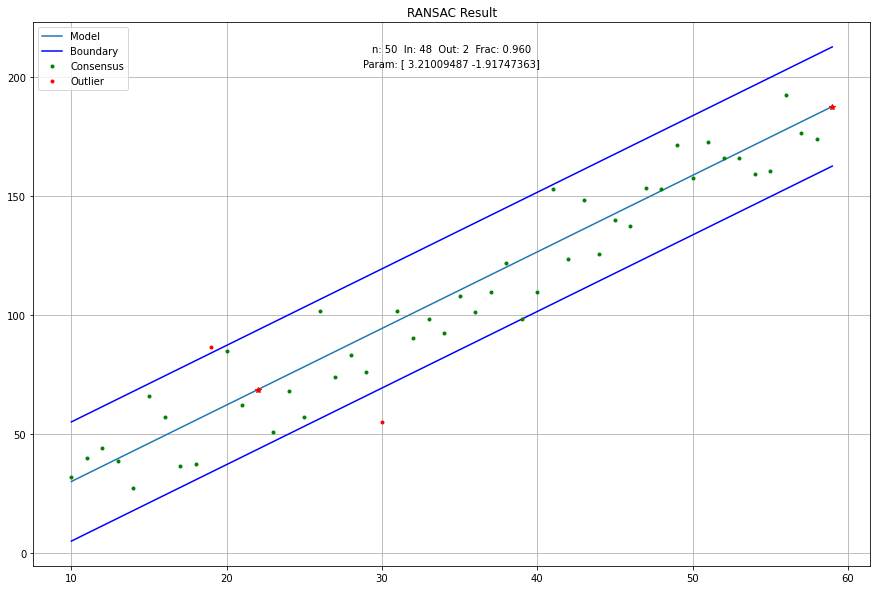

In [11]:
ransac.plot()

##  Now create a quadratic RANSAC Object

In [12]:
class QuadraticRANSAC(RANSAC_Core):
    
    def dof(self):
        """Return degrees-of-freedom for linear model."""
        return 3
    
    def fit(self,x:np.ndarray,y:np.ndarray)->np.ndarray:
        """Quadratic fit to three samples."""
        gamma = - (x[1] - x[0]) / (x[2] - x[0])
        a = (y[1] - y[0] + gamma * (y[2] - y[0])) / ((x[1]**2 - x[0]**2) + gamma * (x[2]**2 - x[0]**2))
        b = ( (y[2] - y[0]) - a * (x[2]**2 - x[0]**2) ) / (x[2] - x[0])
        c = y[0] - a * x[0]**2 - b * x[0]
        return np.array([a,b,c])

    def predict(self,param:np.ndarray,x:np.ndarray)->np.ndarray:
        """Compute prediction from model."""
        return x * x * param[0] + x * param[1] + param[2]

In [13]:
qRansac = QuadraticRANSAC(x,y,15)

In [14]:
qRansac.run()

0.8

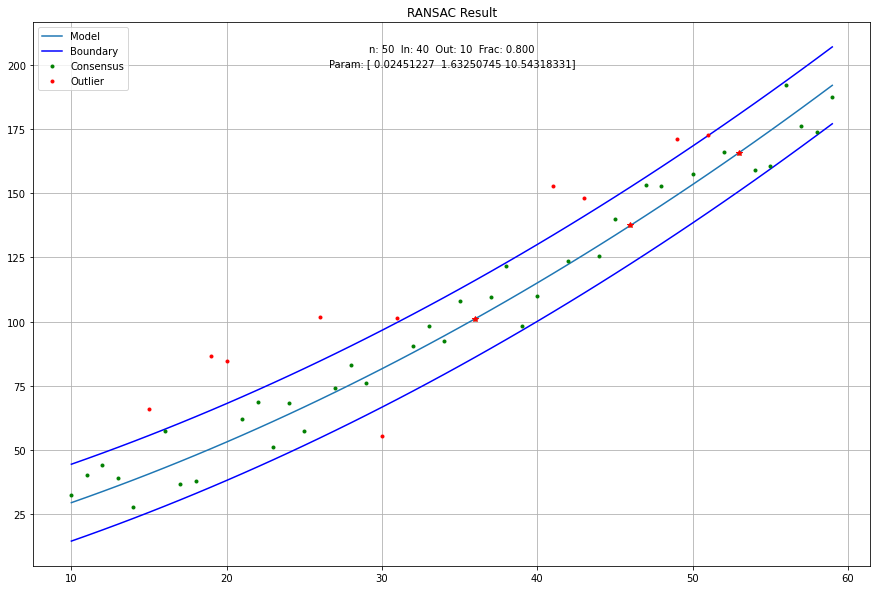

In [15]:
qRansac.plot()